# Chapter 9: Classification and Regression Trees (CART)

Make sure DMBA package is available

In [18]:
pip install dmba

In [19]:
# Import required packages for this chapter
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import matplotlib.pylab as plt

import dmba
from dmba import plotDecisionTree, gainsChart, liftChart
from dmba import classificationSummary, regressionSummary

%matplotlib inline

# Problem 9.1 Competitive Auctions on eBay.com.

The file _eBayAuctions.csv_ contains information on 1972 auctions that transacted on eBay.com during May–June 2004. The goal
is to use these data to build a model that will classify auctions as competitive or noncompetitive. A _competitive auction_ is defined as an auction with at least two bids placed on the item auctioned. The data include variables that describe the item (auction category), the seller (his/her eBay rating), and the auction terms that the seller selected (auction duration, opening price, currency, day-of-week of auction close). In addition, we have the price at which the auction closed. The task is to predict whether or not the auction will be competitive.

__Data Preprocessing.__ Convert variable _Duration_ into a categorical variable. Split the
data into training (60%) and validation (40%) datasets.

## Data Preprocessing

In [20]:
# Load the data
ebay_df = dmba.load_data('eBayAuctions.csv')

# convert categorical variables into indicator and drop the first column of each of them
ebay_df = pd.get_dummies(ebay_df, prefix_sep='_')
ebay_df.drop(columns=['Category_Antique/Art/Craft', 'currency_EUR', 'endDay_Fri'], inplace=True)

ebay_df.head()
ebay_df.shape

(1972, 30)

In [21]:
# remove question mark from response name
ebay_df.columns = [c.replace('?', '') for c in ebay_df.columns]

# convert variable Duration to categorical data type
ebay_df['Duration'].astype('category')

# Separate out predictors and outcome variable
X = ebay_df.drop(columns='Competitive')
y = ebay_df['Competitive']


In [22]:
# partition the data into training (60%) and validation (40%) sets. use random_state=1 for reproducibility of results
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

__9.1.a.__ Fit a classification tree using all predictors. To avoid overfitting, set the minimum number of records in a terminal node to 50 and the maximum tree depth to 7. Write down the results in terms of rules. (_Note:_ If you had to slightly reduce the
number of predictors due to software limitations, or for clarity of presentation, which would be a good variable to choose?)

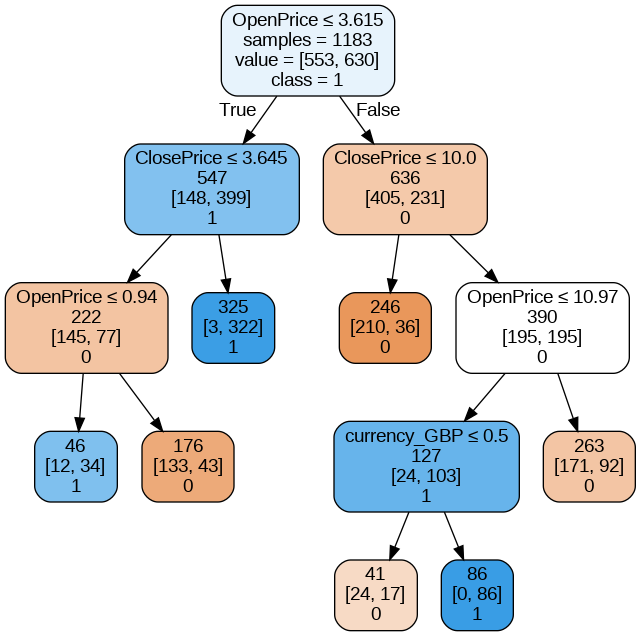

In [23]:
# fit the tree
smallClassTree = DecisionTreeClassifier(max_depth=7, min_samples_split=50, min_impurity_decrease=0.01)
smallClassTree.fit(train_X, train_y)
plotDecisionTree(smallClassTree, feature_names=ebay_df.columns[:29], class_names=smallClassTree.classes_)

__9.1.b.__ Is this model practical for predicting the outcome of a new auction?

__9.1.c.__ Describe the interesting and uninteresting information that these rules provide.

__9.1.d.__ Fit another classification tree (using a tree with a minimum number of records per terminal node = 50 and maximum depth = 7), this time only with predictors that can be used for predicting the outcome of a new auction. Describe the resulting
tree in terms of rules. Make sure to report the smallest set of rules required for classification.

__Answer:__

In [24]:
ebay_df.columns

Index(['sellerRating', 'Duration', 'ClosePrice', 'OpenPrice', 'Competitive',
       'Category_Automotive', 'Category_Books', 'Category_Business/Industrial',
       'Category_Clothing/Accessories', 'Category_Coins/Stamps',
       'Category_Collectibles', 'Category_Computer', 'Category_Electronics',
       'Category_EverythingElse', 'Category_Health/Beauty',
       'Category_Home/Garden', 'Category_Jewelry', 'Category_Music/Movie/Game',
       'Category_Photography', 'Category_Pottery/Glass',
       'Category_SportingGoods', 'Category_Toys/Hobbies', 'currency_GBP',
       'currency_US', 'endDay_Mon', 'endDay_Sat', 'endDay_Sun', 'endDay_Thu',
       'endDay_Tue', 'endDay_Wed'],
      dtype='object')

In [25]:
# Select only those variables which can be used for predicting the outcome of new auction.

# Create a new dataframe with predictors
predictors_df = ebay_df

columns = list(ebay_df.columns)
columns

columns.remove('ClosePrice')
columns.remove('endDay_Mon')
columns.remove('endDay_Sat')
columns.remove('endDay_Sun')
columns.remove('endDay_Thu')
columns.remove('endDay_Tue')
columns.remove('endDay_Wed')
ebay_df = ebay_df[columns]
ebay_df.columns

Index(['sellerRating', 'Duration', 'OpenPrice', 'Competitive',
       'Category_Automotive', 'Category_Books', 'Category_Business/Industrial',
       'Category_Clothing/Accessories', 'Category_Coins/Stamps',
       'Category_Collectibles', 'Category_Computer', 'Category_Electronics',
       'Category_EverythingElse', 'Category_Health/Beauty',
       'Category_Home/Garden', 'Category_Jewelry', 'Category_Music/Movie/Game',
       'Category_Photography', 'Category_Pottery/Glass',
       'Category_SportingGoods', 'Category_Toys/Hobbies', 'currency_GBP',
       'currency_US'],
      dtype='object')

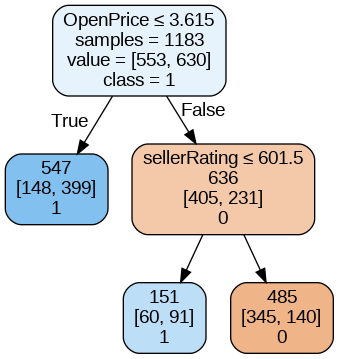

In [26]:
# separate out the predictors and response variable
X1 = ebay_df.drop(columns='Competitive')
y1 = ebay_df['Competitive']

# partition the data into training (60%) and validation (40%) sets. Set random_state=1 for reproducibility of results
train_X1, valid_X1, train_y1, valid_y1 = train_test_split(X1, y1, test_size=0.4, random_state=1)

# fit the tree
smallClassTree1 = DecisionTreeClassifier(max_depth=7, min_samples_split=50, min_impurity_decrease=0.01)
smallClassTree1.fit(train_X1, train_y1)
plotDecisionTree(smallClassTree1, feature_names=ebay_df.columns[:22], class_names=smallClassTree1.classes_)

Set of rules

If (OpenPrice <= 3.615) then class = 1

If (OpenPrice > 3.615) and (sellerRating <= 601.5) then class = 1

If (OpenPrice > 3.615) and (sellerRating > 601.5) then class = 0

__9.1.e.__ Plot the resulting tree on a scatter plot: Use the two axes for the two best (quantitative) predictors. Each auction will appear as a point, with coordinates corresponding to its values on those two predictors. Use different colors or symbols
to separate competitive and noncompetitive auctions. Draw lines (you can sketch these by hand or use Python) at the values that create splits. Does this splitting seem reasonable with respect to the meaning of the two predictors? Does it seem to do
a good job of separating the two classes?

__Answer:__

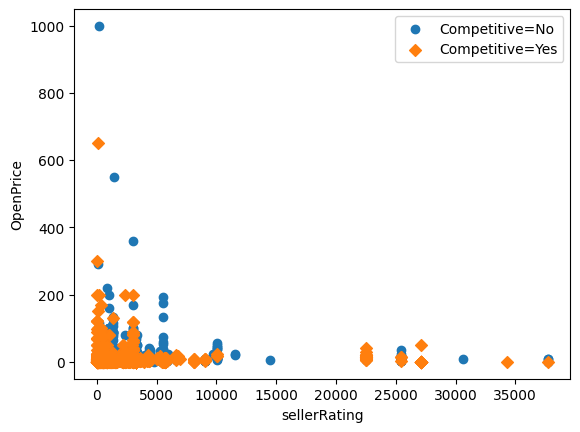

In [27]:
# plot sellerRating vs. OpenPrice
fig, ax = plt.subplots()

subset = ebay_df.loc[ebay_df['Competitive']== 0]
ax.scatter(subset.sellerRating, subset.OpenPrice, marker='o', label='Competitive=No')

subset1 = ebay_df.loc[ebay_df['Competitive']== 1]
ax.scatter(subset1.sellerRating, subset1.OpenPrice, marker='D', label='Competitive=Yes')

plt.xlabel('sellerRating')  # set x-axis label
plt.ylabel('OpenPrice')  # set y-axis label

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

The splitting points are located way down in the lower left corner so the scatterplot does not reveal much to answer the question. We could do a log transform, or restrict the scatterplot to the smaller values.

__9.1.f.__ Examine the lift chart and the confusion matrix for the tree. What can you say about the predictive performance of this model?

__Answer:__

In [28]:
# predicted classes
pred_t = smallClassTree1.predict(train_X1)
pred_v = smallClassTree1.predict(valid_X1)

# predicted probabilities for validation set
pred_prob_v = (smallClassTree1.predict_proba(valid_X1))

# put it together in a data frame
tree_result = pd.DataFrame({'actual': valid_y1,
                           'p(0)': [p[0] for p in pred_prob_v],
                           'p(1)': [p[1] for p in pred_prob_v],
                           'predicted': pred_v})
tree_result.head()

,actual,p(0),p(1),predicted
1287,0,0.711340,0.288660,0
1017,1,0.270567,0.729433,1
1047,0,0.711340,0.288660,0
108,1,0.270567,0.729433,1
1084,1,0.711340,0.288660,0


In [ ]:
# confusion matrices for training and validation sets
print('Training Set: Confusion matrix\n')
classificationSummary(train_y1, pred_t)
print("\nValidation Set: Confusion matrix\n")
classificationSummary(valid_y1, pred_v)

Training Set: Confusion matrix

Confusion Matrix (Accuracy 0.7058)

       Prediction
Actual   0   1
     0 345 208
     1 140 490

Validation Set: Confusion matrix

Confusion Matrix (Accuracy 0.7072)

       Prediction
Actual   0   1
     0 228 125
     1 106 330


<Axes: xlabel='Percentile', ylabel='Lift'>

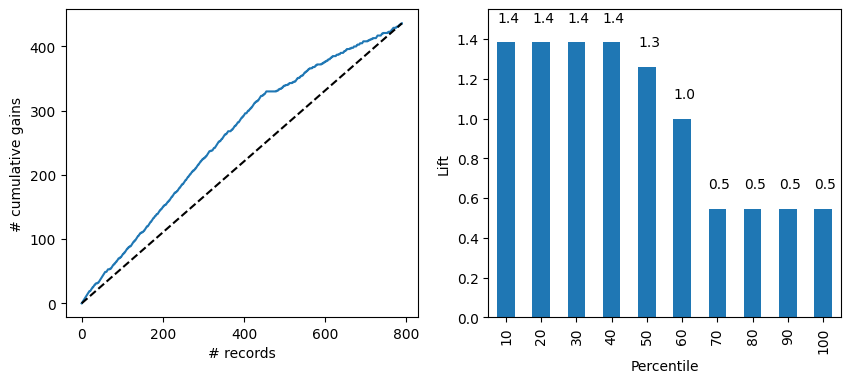

In [29]:
# lift chart for validation set
df = tree_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])

From the lift chart we see that the model's predictive performance (i.e. correctly capturing the auctions that are most likely to be competitive) is better than the baseline model, since its lift curve is higher than that of the baseline model. The decile lift chart has a limited set of lift values because the tree is a simple one, producing only three potential predicted probabilities.

__9.1.g.__ Based on this last tree, what can you conclude from these data about the chances of an auction obtaining at least two bids and its relationship to the auction settings set by the seller (duration, opening price, ending day, currency)? What would you recommend for a seller as the strategy that will most likely lead to a competitive auction?